# Data Validation and some simple Statistics

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from glob import glob

First read in the table with the generally available metadata from the CODH.

In [3]:
overview = pd.read_csv("bukan-overview.csv")

Next, I drop all the lines where I manually decided to not consider the book. This is mostly because is was not a book to begin with or the scan was useless.

In [4]:
data = overview[overview["K?"] == "x"].drop("K?", 1)

Just checking if the `metadata.json` and the actual number of images is consistent. 

In [5]:
label_mapping = {}
for idx in data["国文研書誌ID"]:
    idx = int(idx)
    with open(f"data/{idx}/manifest.json", "r", encoding="utf-8") as fd:
        manifest = json.load(fd)
        label = manifest["label"]
        alt_label = manifest["metadata"][3]["value"]
        if label in label_mapping and label_mapping[label] != alt_label:
            print(f"Inconsistent alternative label in {idx}: {label} <-> {alt_label}")
        label_mapping[label] = alt_label
        nr_pages = len(manifest["sequences"][0]["canvases"])
    images = glob(f"data/{idx}/image/*")
    if len(images) != nr_pages: print(f"WARNING book {idx}: {len(images)} images, {nr_pages} manifest pages")
    # print(f"book {idx}: {len(images)} images, {nr_pages} manifest pages")

WARNING book 200019503: 181 images, 180 manifest pages


## Mapping the names to latin letters

An hiragana reading is already included in the `metadata.json` but it's easier for me and for visualization to have latin letters. Therefore I created a manual mapping:

In [6]:
hiragana_mapping = {
    'ほんちょうぶかん': "honchōbukan",
    'たいへいぶかん': "taihenbukan",
    'たいへいぶかんたいぜん': "taihenbukantaizen",
    'せいとうぶかん': "seitōbukan",
    'げんろくぶかんたいぜん': "genrokubukantaizen",
    'ほうえいぶかんたいせい': "hōeibukantaisen",
    'ごりんぶかん': "gorinbukan",
    'ほうえいぶかん': "hōeibukan",
    'しょうふうぶかん': "shōfūbukan",
    'しょうえんぶかん': "shōenbukan",
    'しょうとくぶかん': "shōtokubukan",
    'きょうほうぶかん': "kyōhōbukan",
    'えいせいぶかん': "eiseibukan", 
    'げんぶんぶかん': "genbunbukan",
    'かんぽうぶかん': "kanpōbukan",
    'えんきょうぶかん': "enkyōbukan",
    'かんえんぶかん': "kanenbukan",
    'ゆうしぶかん': "yūshibukan",
    'ほうりゃくぶかん': "hōryakubukan",
    'たいせいぶかん': "taiseibukan",
    'めいわぶかん': "meiwabukan",
    'たいへいりゃくぶかん': "taiheiryakubukan",
    'しゅうぎょくぶかん': "shūgyokubukan",
    'あんえいぶかん': "aneibukan",
    'しゅうちんぶかん': "shūchinbukan",
    'てんめいぶかん': "tenmeibukan",
    'まんじゅぶかん': "manjubukan",
    'かんせいぶかん': "kanseibukan",
    'きょうわぶかん': "kyōwabukan",
    'ぶんかぶかん': "bunkabukan",
    'ぶんせいぶかん': "bunseibukan",
    'かまくらぶかん': "kamakurabukan",
    'かいほうりゃくぶかん': "kaihōryakubukan", 
    'てんぽうぶかん': "tenpōbukan",
    'おうにんぶかん': "ōninbukan",
    'こうかぶかん': "kōkabukan",
    'ばんせいぶかん': "banseibukan",
    'かえいぶかん': "kaeibukan",
    'しょうえいぶかん': "shōeibukan",
    'あんせいぶかん': "anseibukan",
    'ぶんきゅうぶかん': "bunkyūbukan",
    'けいおうぶかん': "keiōbukan",
    'おくにわけぶかん': "okuniwakebukan",
    'かいほうおくにわけりゃくぶかん': "kaihō okuniwake ryakubukan"
}

## How many of the same Bukan do we have?
There are many editions of the same bukan. But how are these distributed exactly? Let's plot the book title and the number of books!

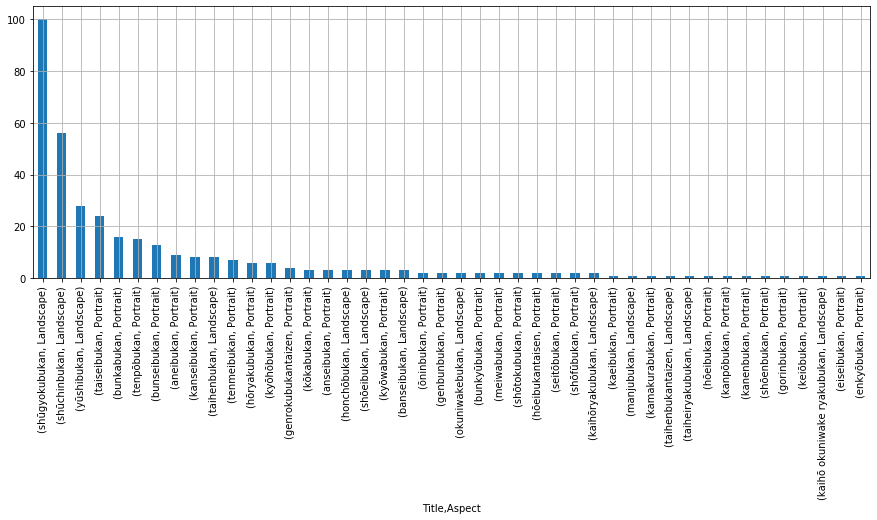

In [44]:
count_by_name = data.groupby(["書名（統一書名）", "Aspect"]).count()["国文研書誌ID"]
count_by_name_index = count_by_name.index.map(lambda idx: (hiragana_mapping[label_mapping[idx[0]]], idx[1]))
count_by_name_index = count_by_name_index.set_names(["Title", "Aspect"])
count_by_name_index.name = "Title"
count_by_name.index = count_by_name_index
count_by_name_sorted = count_by_name.sort_values(ascending=False)
axes = count_by_name_sorted.plot(kind="bar", figsize=(15,5), grid=True)

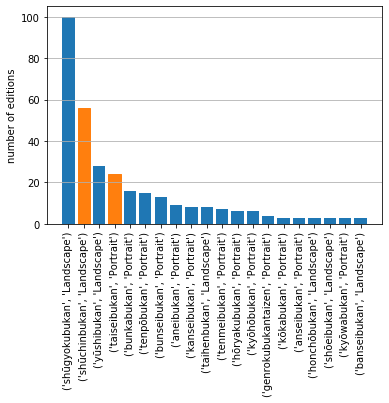

In [46]:
test = count_by_name_sorted[count_by_name_sorted>2]
bars = plt.bar(range(len(test)), test)
plt.ylabel("number of editions")
plt.xticks(range(len(test)), list(test.index), rotation="vertical")
plt.grid(axis="y")
bars[1].set_color("#ff7f0e")
bars[3].set_color("#ff7f0e")
#plt.savefig("bukan-distribution.pdf", transparent=True, bbox_inches="tight")

## Filtering out books

We can not compare books when there are not multiple editions available. Therefore I remove these lines from the overview table.

In [9]:
count_by_name_jap = data.groupby("書名（統一書名）").count()["国文研書誌ID"]
thresholded_larger_1 = data[data["書名（統一書名）"].map(lambda x: x in set(count_by_name_jap[count_by_name_jap > 1].index))]
thresholded_larger_1.shape

(338, 13)

### Shūgyoku Bukan

And this is the Bukan with the most editions:

The **袖玉武鑑** (しゅうぎょくぶかん) (shūgyokubukan)

In [10]:
shuugyokubukan = data[data["書名（統一書名）"] == "袖玉武鑑"]

In [12]:
# Output CSV for easier analysis in other software
shuugyokubukan.drop(
    ["書名（統一書名）", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
#    "shuugyokubukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）,Pages per Scan,Aspect
170,200019397,ＭＹ－１２０１－２２５,宝暦１４,1764,1.0,Landscape
172,200019400,ＭＹ－１２０１－２２７,天明８,1788,1.0,Landscape
173,200019401,ＭＹ－１２０１－２２８,天明９,1789,1.0,Landscape
175,200019406,ＭＹ－１２０１－２３０,寛政１０,1798,1.0,Landscape
176,200019408,ＭＹ－１２０１－２３１,文化３,1806,1.0,Landscape
...,...,...,...,...,...,...
348,200019639,ＭＹ－１２０１－３１２,慶応３,1867,1.0,Landscape
350,200019641,ＭＹ－１２０１－３１２,慶応３,1867,1.0,Landscape
352,200019643,ＭＹ－１２０１－３１２,慶応３,1867,1.0,Landscape
354,200019646,ＭＹ－１２０１－３１３,慶応３,1867,1.0,Landscape


### Shūchin Bukan

Since most of the Bukan from above are really bad quality (better to look at this later) let's inspect the second most frequent:

The **袖珍武鑑** (しゅうちんぶかん) (shūchinbukan)

In [13]:
shuuchinbukan = data[data["書名（統一書名）"] == "袖珍武鑑"]

In [14]:
# Output CSV for easier analysis in other software
shuuchinbukan.drop(
    ["書名（統一書名）", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
    #"shuuchinbukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）,Pages per Scan,Aspect
171,200019399,ＭＹ－１２０１－２２６,安永７,1778,1.0,Landscape
181,200019413,ＭＹ－１２０１－２３６,文化６,1809,1.0,Landscape
187,200019419,ＭＹ－１２０１－２４２,文政７,1824,1.0,Landscape
191,200019423,ＭＹ－１２０１－２４６,天保８,1837,1.0,Landscape
195,200019429,ＭＹ－１２０１－２５１,天保１１,1840,1.0,Landscape
196,200019430,ＭＹ－１２０１－２５２,天保１２,1841,1.0,Landscape
209,200019451,ＭＹ－１２０１－２６６,嘉永４,1851,1.0,Landscape
216,200019461,ＭＹ－１２０１－２７４,安政４,1857,1.0,Landscape
218,200019464,ＭＹ－１２０１－２７６,安政５,1858,1.0,Landscape
251,200019509,ＭＹ－１２０１－２９１,文久３,1863,1.0,Landscape


### Yūshi Bukan

This looks better; but for completeness let's also process the third most frequent:

The **有司武鑑** (ゆうしぶかん) (yūshibukan)

In [15]:
yuushibukan = data[data["書名（統一書名）"] == "有司武鑑"]

In [16]:
# Output CSV for easier analysis in other software
yuushibukan.drop(
    ["書名（統一書名）", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
    #"yuushibukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）,Pages per Scan,Aspect
167,200019391,ＭＹ－１２０１－２２２,寛延１,1748,2.0,Landscape
168,200019394,ＭＹ－１２０１－２２３,宝暦２,1752,2.0,Landscape
189,200019421,ＭＹ－１２０１－２４４,文政１３,1830,1.0,Landscape
194,200019428,ＭＹ－１２０１－２５０,天保９,1838,1.0,Landscape
201,200019439,ＭＹ－１２０１－２５７,天保１５,1844,1.0,Landscape
204,200019443,ＭＹ－１２０１－２６１,弘化４,1847,1.0,Landscape
205,200019444,ＭＹ－１２０１－２６２,嘉永２,1849,1.0,Landscape
207,200019446,ＭＹ－１２０１－２６４,嘉永３,1850,1.0,Landscape
208,200019448,ＭＹ－１２０１－２６５,嘉永３,1850,1.0,Landscape
213,200019456,ＭＹ－１２０１－２７０,安政２,1855,1.0,Landscape
